In [40]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from tqdm import tqdm
import h5py

In [41]:
OUT_TENSOR_SIZE = 64
TEST_TRAIN_SPLIT_RATIO = 0.8

In [42]:
data_name = "data/peak_100k"

Tgt = np.loadtxt("%s.txt"%data_name)
print(Tgt.shape)
peaks_n = Tgt[:,1]

Idata = cv.imread("%s.bmp"%data_name, cv.IMREAD_GRAYSCALE)
print(Idata.shape)

for i in range(int(Tgt.shape[0])):
    
    signal = Idata[i,:];
    
    for j in range(int(Tgt[i,1])):
        
        peak_pos = round(Tgt[i,j*3+2]);
        idx_from = int(max(0,peak_pos-2));
        idx_to = int(min(Idata.shape[1],peak_pos+2));
        height = max(signal[idx_from:idx_to]); # find correct signal height in the neighbourhood
        Tgt[i,j*3+3] = height;
    
    


(100000, 11)
(100000, 1024)


In [43]:
max_peak_height = np.amax(Tgt[:,3])
print("Max peak height: ",max_peak_height)

max_peak_std = np.amax(Tgt[:,4])
print("Max peak std: ",max_peak_std)

Max peak height:  255.0
Max peak std:  10.0


Signal #10005
---------------------------
Out GT:  [750.      3.    196.838 151.      1.267 705.261  64.      2.775 214.933
 209.      6.465]
Peak pos:  196.838
Peak height:  151.0
Peak std:  1.267
Peak pos:  705.261
Peak height:  64.0
Peak std:  2.775
Peak pos:  214.933
Peak height:  209.0
Peak std:  6.465
---------------------------
 
Signal #10006
---------------------------
Out GT:  [564.      2.    221.566 207.      6.405 289.41  164.      9.099   0.
   0.      0.   ]
Peak pos:  221.566
Peak height:  207.0
Peak std:  6.405
Peak pos:  289.41
Peak height:  164.0
Peak std:  9.099
---------------------------
 
Signal #10007
---------------------------
Out GT:  [811.      3.    592.581 167.      4.267 799.041 107.      0.813  83.621
  60.      8.967]
Peak pos:  592.581
Peak height:  167.0
Peak std:  4.267
Peak pos:  799.041
Peak height:  107.0
Peak std:  0.813
Peak pos:  83.621
Peak height:  60.0
Peak std:  8.967
---------------------------
 
Signal #10008
---------------------------
O

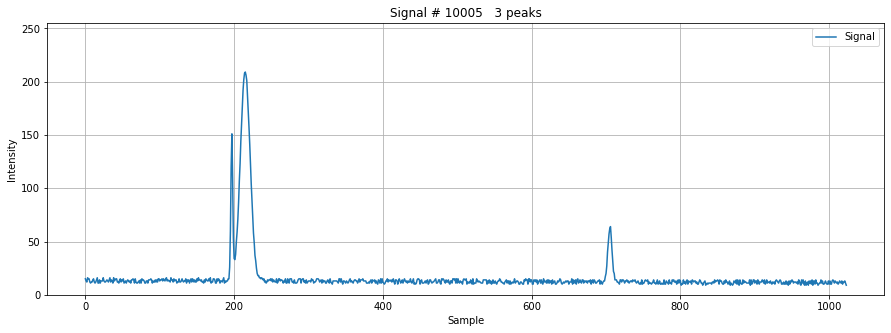

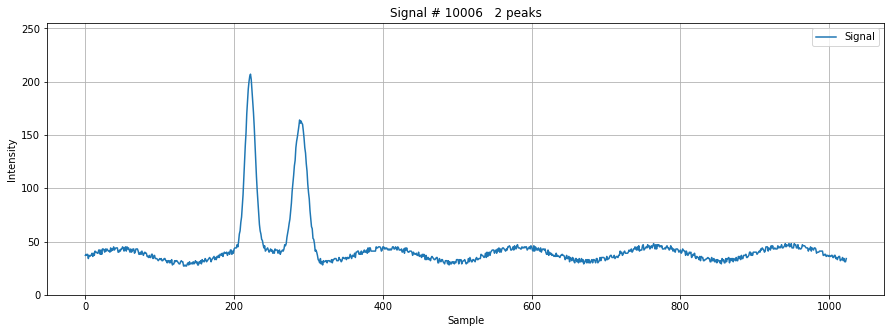

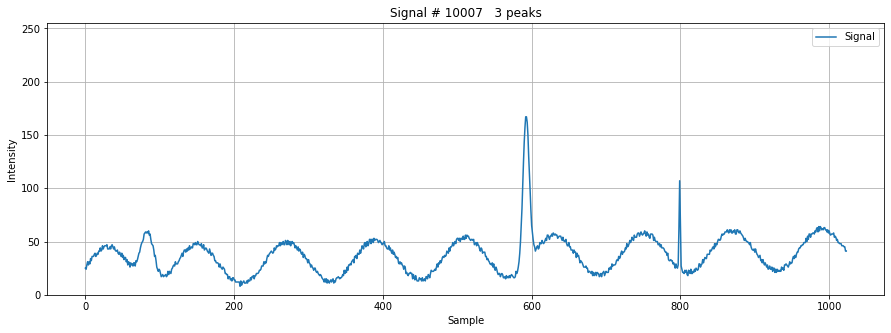

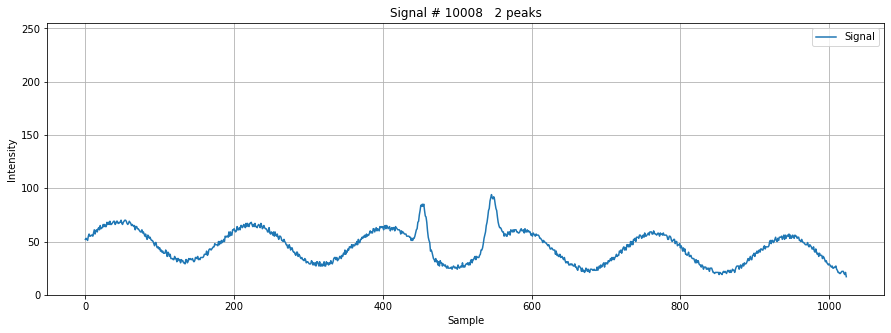

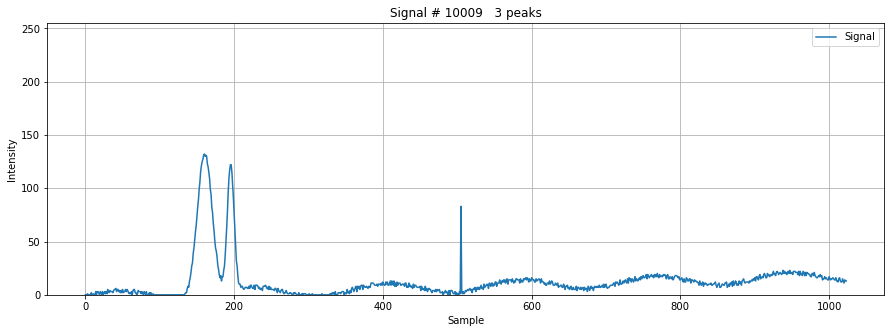

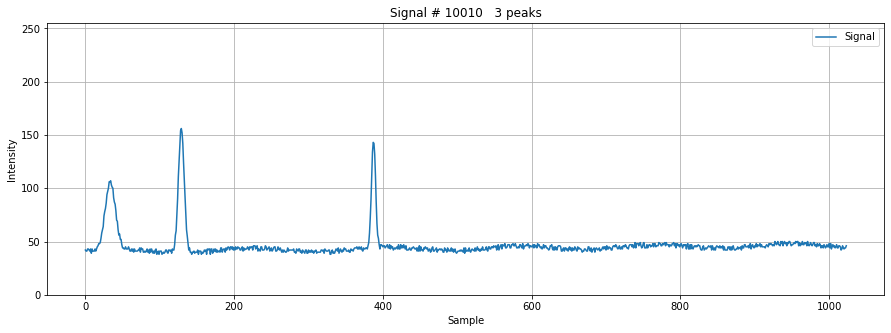

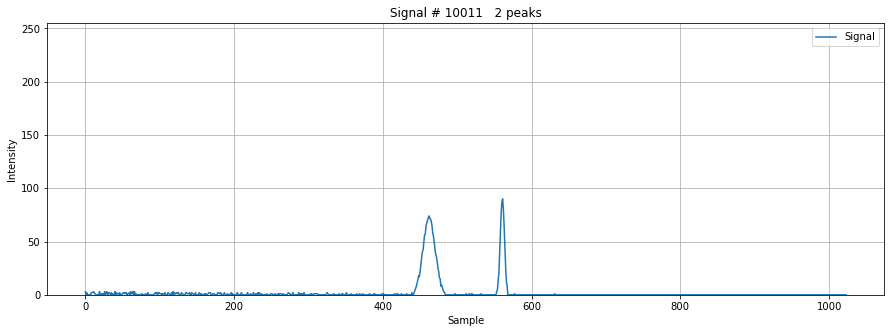

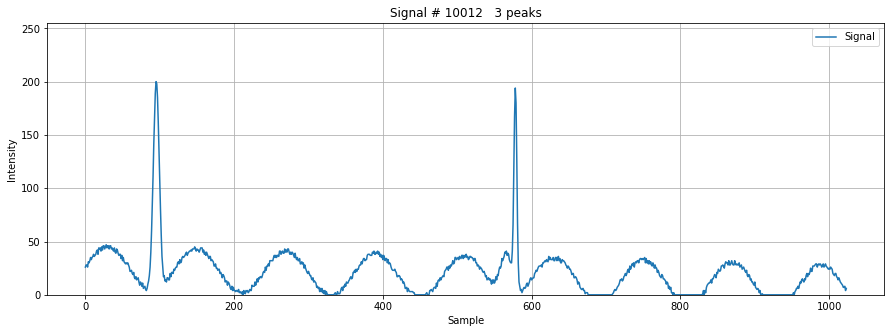

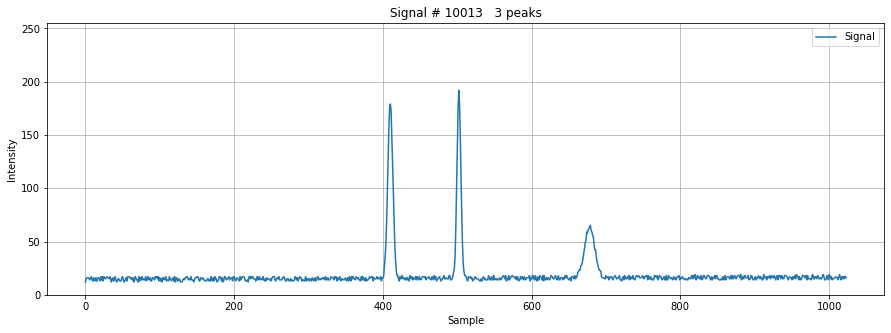

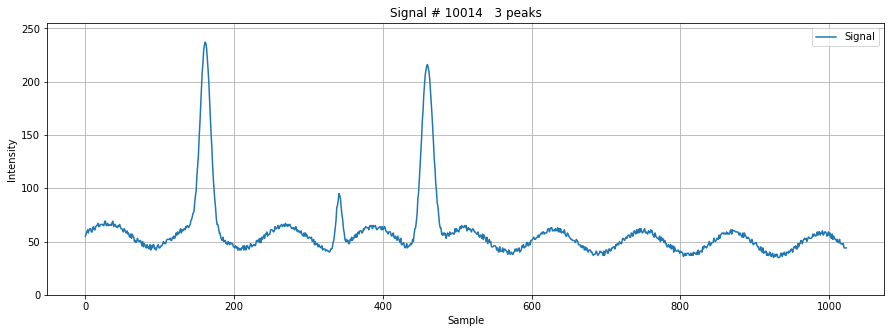

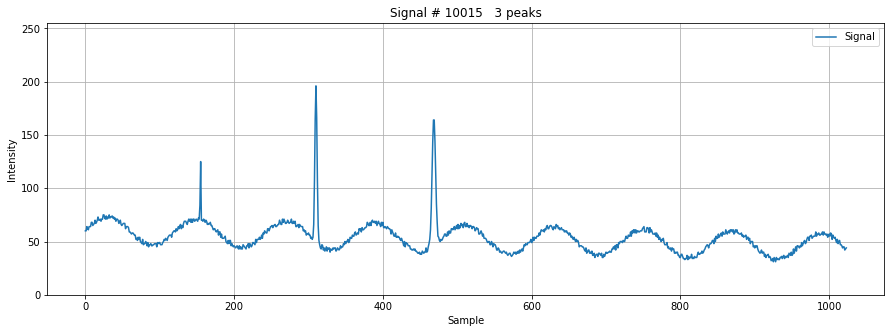

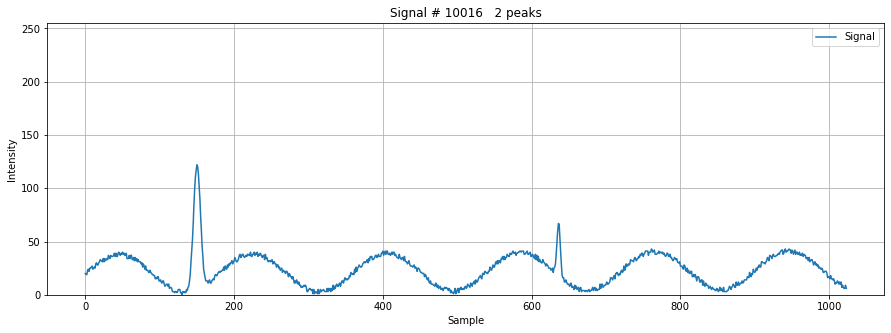

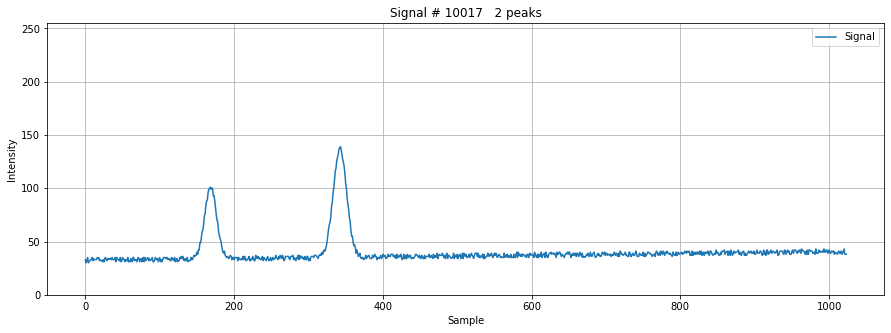

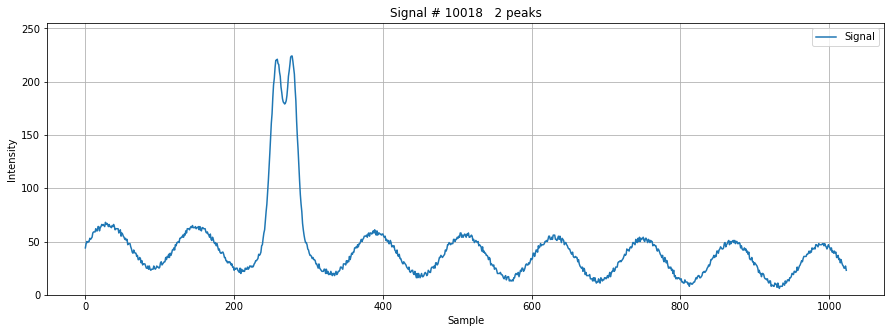

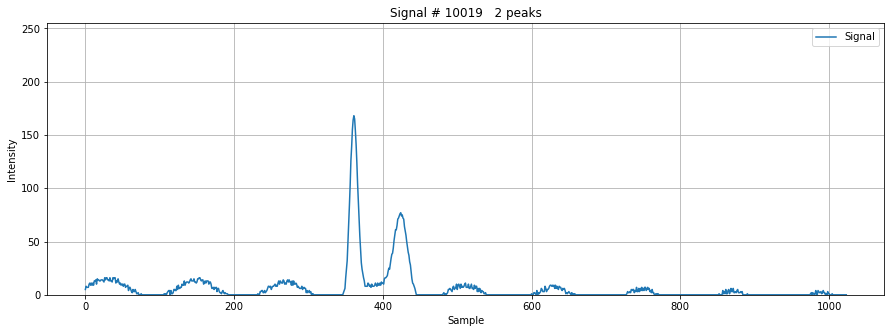

In [44]:
for N in range(10005,10020):
    #N = 10009
    #N = 29860

    npeaks = int(peaks_n[N])

    plt.figure(figsize=(15,5))
    plt.plot( Idata[N,:] )
    plt.title("Signal # %d   %d peaks"%(N,npeaks))
    plt.ylim( 0, 255)
    plt.grid("minor")
    plt.xlabel("Sample")
    plt.ylabel("Intensity")

    curves=["Signal"]
    print("Signal #%d"%N)
    print("---------------------------")
    print("Out GT: ", Tgt[N,:])
    for ii in range(npeaks):
        peakpos=Tgt[N,1+ii*3+1]
        peakheight=Tgt[N,1+ii*3+2]
        peakstd=Tgt[N,1+ii*3+3]
        print("Peak pos: ", peakpos)
        print("Peak height: ",peakheight)
        print("Peak std: ", peakstd)
        gsignal = np.roll( scipy.signal.gaussian( Idata.shape[1], std=peakstd )*peakheight, int(peakpos-Idata.shape[1]/2) )
        #plt.plot( gsignal, '.-')
        curves.append("Peak #%d - pos %3.2f"%(ii+1, peakpos))
        
    print("---------------------------")
    print(" ")

    plt.legend( curves )
    file_name = "plots/debug/data_"+str(N)+"_plot_size_"+str(OUT_TENSOR_SIZE)+".png"
    plt.savefig(file_name)


In [48]:
%load_ext autoreload
%autoreload 1
%aimport evaluator
%aimport DataTensorConverter

from DataTensorConverter import DataTensorConverter

N = 10016
    
dc = DataTensorConverter( input_size=Idata.shape[1], out_size=OUT_TENSOR_SIZE, max_height=max_peak_height, max_std=max_peak_std )
print("Min detectable distance: %3.2f px"%dc.min_detectable_peak_distance() )

#Tgt[N,...] = np.array([0, 1, 135, 100, 3, 0, 0, 0, 0, 0, 0 ])

print( Tgt[N,1:] )
t = dc.to_tensor( Tgt[N,1:] )
print( t.shape )
print(t)

data = dc.to_data( t )
print( data )


import pickle
with open("data/datatensorconverter.pickle","wb") as f:
    pickle.dump( dc, f )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Min detectable distance: 16.00 px
[  2.    150.066 122.      4.6   636.184  67.      2.193   0.      0.
   0.   ]

      Peak:  150.066
arraypos_f:  9.379125
  arraypos:  9
     displ:  0.7582500000000003

      Peak:  636.184
arraypos_f:  39.7615
  arraypos:  40
     displ:  -0.47700000000000387
(64, 4)
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 1.          0.75825     0.47843137  0.46      ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.    

In [ ]:
def generate_dataset( name, indices ):
    filename =  "data/%s.h5"%name
    print("Generating ",filename )
    with h5py.File(filename, "w") as f:
        dset_x = f.create_dataset( "x", (1,Idata.shape[1],1), maxshape=(None,Idata.shape[1],1),
                                         dtype='float32', chunks=(32,Idata.shape[1],1))

        out_shape = dc.out_tensor_shape()
        dset_y = f.create_dataset( "y", (1,out_shape[0],out_shape[1]), maxshape=(None,out_shape[0],out_shape[1]),
                                         dtype='float32', chunks=(32,out_shape[0],out_shape[1]))

        curr_idx=0
        for ii in tqdm(indices): #trange(Idata.shape[0]):
            if dset_x.shape[0]<=curr_idx:
                dset_x.resize( (dset_x.shape[0]+1,dset_x.shape[1],dset_x.shape[2]) )
                dset_y.resize( (dset_y.shape[0]+1,dset_y.shape[1],dset_y.shape[2]) )

            try:
                T = dc.to_tensor( Tgt[ii,1:] )
                data = dc.to_data( T )
                                
                if (data[0]>0) and (data[1]==0):
                    print("------------ ", ii)
                    print(data)
                    print( Tgt[ii,1:] )
                    print( T )
                    print( T.shape )
                    break
                    
                    
                dset_x[curr_idx,:,:] = np.expand_dims( Idata[ii,:], axis=-1 )
                dset_y[curr_idx,:,:] = T

                curr_idx = curr_idx+1

            except ValueError as e:
                #print(e)
                pass
            

allindices = range(Idata.shape[0])
print(len(allindices))
generate_dataset( "data/train_100k_"+str(OUT_TENSOR_SIZE), allindices[ :int(len(allindices)*TEST_TRAIN_SPLIT_RATIO) ])
generate_dataset( "data/test_100k_"+str(OUT_TENSOR_SIZE), allindices[ int(len(allindices)*TEST_TRAIN_SPLIT_RATIO): ])